# **Studio della diffusività e dei tempi caratteristici del fenomeno**

In [1]:
# Pulizia
from IPython import get_ipython
get_ipython().magic('clear')
get_ipython().magic('reset -f')

# Import libraries:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
from scipy.sparse.linalg import splu
from scipy.linalg import lu_factor
import itertools
import time
import os
import sys
import json
import pandas as pd

# Import user defined libraries:
from FreeFEM import FFmatrix_fread, FFvector_fread

/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_4492/1511052661.py:3: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('clear')
/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_4492/1511052661.py:4: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('reset -f')


### **Diffusività massima - fenomeno rapido**

[[3.09675480e-13]
 [3.09676286e-13]
 [3.09671289e-13]
 ...
 [6.16260359e-16]
 [6.16260359e-16]
 [6.01151252e-16]]


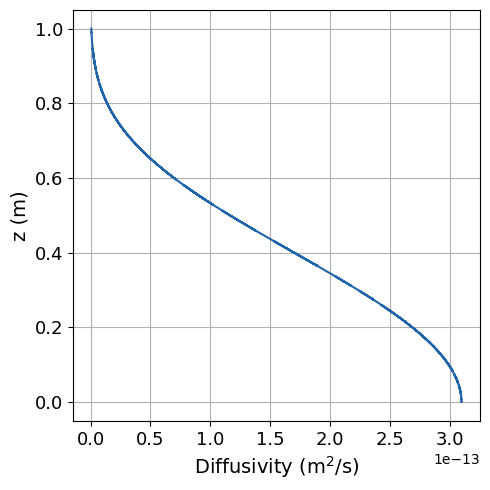

In [2]:
# Define parameters ranges:
MIN_FR, MAX_FR = 0.00, 5.00E+19        
MIN_K, MAX_K =  0.9, 8.00    
MIN_LL, MAX_LL = 0.1E-3, 1.50E-3
MIN_BC, MAX_BC = 300, 2.5E+03 

# Lettura dei parametri di riferimento dal file JSON
with open("reference case/Reference_parameters.json", "r") as json_file:
    parameters = json.load(json_file)
N_BOLT = parameters["N_BOLT"]  
FISSION_ENERGY = parameters["FISSION_ENERGY"]         

#Scelti seguendo la logica
FISSION_RATE = MAX_FR              
LENGTH = MAX_LL              
FUEL_THERMAL_CONDUCTIVITY = MIN_K
T_BC = MAX_BC
GAMMA_T = (FISSION_RATE * FISSION_ENERGY * LENGTH**2)/(FUEL_THERMAL_CONDUCTIVITY)

def ALPHA_C(ZZ, T_BC=T_BC, GAMMA_T=GAMMA_T, FISSION_RATE=FISSION_RATE):
    return 7.60E-10 * np.exp(- 4.86E-19 / (T_BC + GAMMA_T * (1 - ZZ**2) / 2) / N_BOLT) + \
           5.64E-25 * np.exp(- 1.91E-19 / (T_BC + GAMMA_T * (1 - ZZ**2) / 2) / N_BOLT) * np.sqrt(FISSION_RATE) + \
           8.00E-40 * FISSION_RATE

coordinates_Pq = FFvector_fread('mesh_utilities/vv_cc_Pq.btxt')
print(ALPHA_C(coordinates_Pq[:, 1:2]))

cmap = plt.get_cmap('RdBu')
color = cmap(0.9)
fig, (ax1) = plt.subplots(1, figsize=(5,5))
ax1.plot( ALPHA_C(coordinates_Pq[:, 1:2]), coordinates_Pq[:, 1:2], label = '$T_\infty$', color=color, linewidth=1.5)
ax1.tick_params(axis="y", labelsize=13)
ax1.tick_params(axis='x', labelsize=13)
ax1.ticklabel_format(useOffset=False)

#ax1.set_ylim([0, 1])
#ax1.set_xlim([2000, 2250])
ax1.set_ylabel('z (m)',fontsize=14)
ax1.set_xlabel(rf'Diffusivity (m$^2$/s)',fontsize=14)
ax1.grid()
plt.tight_layout()
plt.savefig('plot/Temperature profile.pdf', bbox_inches='tight') 

Massima diffusività trovata: 3.097e-13 m^2/s
Parametri corrispondenti:
  - FISSION_RATE: 5.000e+19
  - FUEL_THERMAL_CONDUCTIVITY: 0.900
  - LENGTH: 1.500e-03
  - T_BC: 2500.0


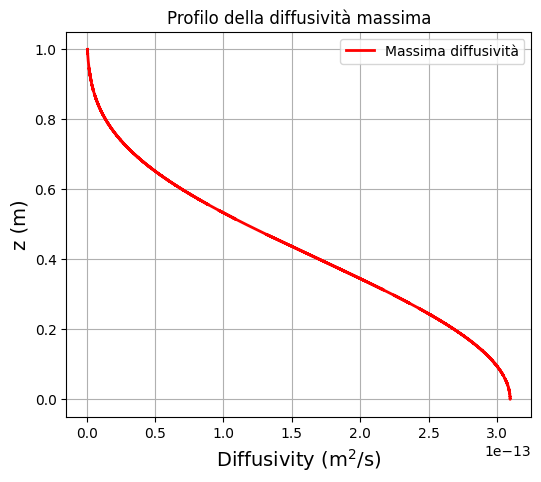

In [3]:
# Lettura parametri di riferimento
with open("reference case/Reference_parameters.json", "r") as json_file:
    parameters = json.load(json_file)
N_BOLT = parameters["N_BOLT"]
FISSION_ENERGY = parameters["FISSION_ENERGY"]

# Definizione dei range dei parametri
MIN_FR, MAX_FR = 0.00, 5.00E+19        
MIN_K, MAX_K =  0.9, 8.00    
MIN_LL, MAX_LL = 0.1E-3, 1.50E-3
MIN_BC, MAX_BC = 300, 2.5E+03 

# Discretizzazione dei parametri (scegli un numero di punti sensato)
N_POINTS = 10  # Puoi aumentare per maggiore precisione
FR_vals = np.linspace(MIN_FR, MAX_FR, N_POINTS)   #sequenza di N-points equidistanti nell'intervallo
K_vals = np.linspace(MIN_K, MAX_K, N_POINTS)
LL_vals = np.linspace(MIN_LL, MAX_LL, N_POINTS)
BC_vals = np.linspace(MIN_BC, MAX_BC, N_POINTS)

# Creazione tutte le combinazioni possibili
param_combinations = itertools.product(FR_vals, K_vals, LL_vals, BC_vals) 

# Definizione della funzione ALPHA_C
def ALPHA_C(ZZ, T_BC, GAMMA_T, FISSION_RATE):
    return 7.60E-10 * np.exp(- 4.86E-19 / (T_BC + GAMMA_T * (1 - ZZ**2) / 2) / N_BOLT) + \
           5.64E-25 * np.exp(- 1.91E-19 / (T_BC + GAMMA_T * (1 - ZZ**2) / 2) / N_BOLT) * np.sqrt(FISSION_RATE) + \
           8.00E-40 * FISSION_RATE

# Creiamo una griglia di punti ZZ lungo l'asse corto per valutare la diffusività
coordinates_Pq = FFvector_fread('mesh_utilities/vv_cc_Pq.btxt')
ZZ_vals =coordinates_Pq[:, 1:2]  # Normalizzato tra -1 e 1

# Variabili per il massimo
max_diffusivity = -np.inf
best_params = None

# Iteriamo su tutte le combinazioni
for FR, K, LL, BC in param_combinations:
    GAMMA_T = (FR * FISSION_ENERGY * LL**2) / K
    diffusivity_values = ALPHA_C(ZZ_vals, BC, GAMMA_T, FR)
    
    # Troviamo il massimo valore di diffusività per questa configurazione
    local_max = np.max(diffusivity_values)

    # Se è il massimo globale finora, lo aggiorniamo
    if local_max > max_diffusivity:
        max_diffusivity = local_max
        best_params = (FR, K, LL, BC)

# Output dei risultati
print(f"Massima diffusività trovata: {max_diffusivity:.3e} m^2/s")
print(f"Parametri corrispondenti:")
print(f"  - FISSION_RATE: {best_params[0]:.3e}")
print(f"  - FUEL_THERMAL_CONDUCTIVITY: {best_params[1]:.3f}")
print(f"  - LENGTH: {best_params[2]:.3e}")
print(f"  - T_BC: {best_params[3]:.1f}")

# Plot della diffusività lungo ZZ per i parametri migliori
GAMMA_T_best = (best_params[0] * FISSION_ENERGY * best_params[2]**2) / best_params[1]
best_diffusivity_values = ALPHA_C(ZZ_vals, best_params[3], GAMMA_T_best, best_params[0])

plt.figure(figsize=(6,5))
plt.plot(best_diffusivity_values, ZZ_vals, label='Massima diffusività', color='r', linewidth=2)
plt.xlabel(r'Diffusivity (m$^2$/s)', fontsize=14)
plt.ylabel('z (m)', fontsize=14)
plt.grid()
plt.legend()
plt.title("Profilo della diffusività massima")
plt.show()

In [4]:
with open("reference case/Reference_parameters.json", "r") as json_file:
    parameters = json.load(json_file)

N_AVOG = parameters["N_AVOG"]  
N_BOLT = parameters["N_BOLT"]  
FISSION_ENERGY = parameters["FISSION_ENERGY"]  
FISSION_RATE = best_params[0]                   
RADIUS = 1e-05
LENGTH = best_params[2]
FISSION_YIELD = parameters["FISSION_YIELD"]                 
FUEL_THERMAL_CONDUCTIVITY = best_params[1]
T_BC = best_params[3]  
C_BC = parameters["C_BC"]  

SOURCE_C = FISSION_RATE * FISSION_YIELD         #[atm / (m^3 s)]
GAMMA_T = (FISSION_RATE * FISSION_ENERGY * LENGTH**2)/(FUEL_THERMAL_CONDUCTIVITY)
     
# Define reference temperature, concentration and linear diffusion parameters:
T_IC  = T_BC # [K]
C_IC = C_BC  # [atm / m^3]


# Define function evaluating the concentration diffusion coefficient at given z coordinated provided the problem parameters:
def ALPHA_C(ZZ, T_BC=T_BC, GAMMA_T=GAMMA_T, FISSION_RATE=FISSION_RATE):
    return 7.60E-10 * np.exp(- 4.86E-19 / (T_BC + GAMMA_T * (1 - ZZ**2) / 2) / N_BOLT) + \
           5.64E-25 * np.exp(- 1.91E-19 / (T_BC + GAMMA_T * (1 - ZZ**2) / 2) / N_BOLT) * np.sqrt(FISSION_RATE) + \
           8.00E-40 * FISSION_RATE

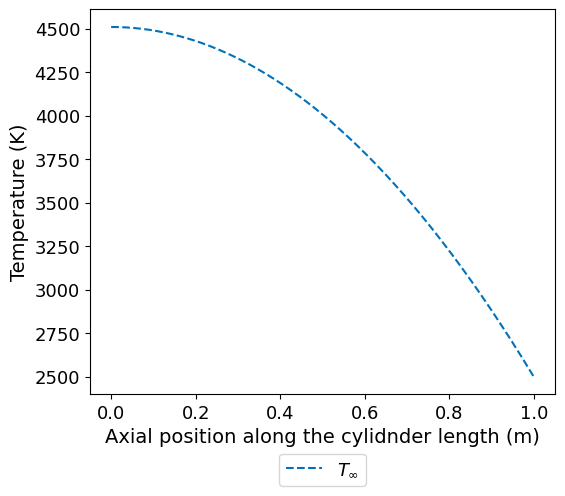

In [5]:
fig, (ax1) = plt.subplots(1, figsize=(6,5))
ax1.plot(np.linspace(0, 1,1000), T_BC + GAMMA_T * (1 - np.linspace(0, 1,1000)**2) / 2, '--',label = '$T_\infty$', color='#0072bd', linewidth=1.5)

ax1.tick_params(axis="y", labelsize=13)
ax1.tick_params(axis='x', labelsize=13)
ax1.ticklabel_format(useOffset=False)
ax1.set_xlabel('Axial position along the cylidnder length (m)',fontsize=14)
ax1.set_ylabel('Temperature (K)',fontsize=14)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), fancybox=True, shadow=False, ncol=2, fontsize=13)

#errore_end= (np.abs((OpenFOAM[-1,1]- (T_BC + GAMMA_T * (1 - np.linspace(0, 1,1000)**2) / 2)))/(OpenFOAM[-1,1]))*100
#print(rf'Relative error (@ final time): {errore_end:.5f}%')

In [6]:
# Load coordinates:
coordinates_Px = FFvector_fread('mesh_utilities/vv_cc_Px.btxt')
coordinates_Pq = FFvector_fread('mesh_utilities/vv_cc_Pq.btxt')

# Identify degrees of freedom of the Px and Pq spaces:
sFO_Px = coordinates_Px.shape[0]
sFO_Pq = coordinates_Pq.shape[0]
print(rf'Degree of freedom = {sFO_Px}')

# Define vector of all Px indeces:
mask_all = np.arange(sFO_Px, dtype=int)

# Identify indeces of the top, bottom and middle boundaries in Px:
mask_inf_bc = mask_all[np.isclose([coordinates_Px[ii, 1] for ii in range(sFO_Px)], np.zeros((sFO_Px)))]
mask_sup_bc = mask_all[np.isclose([coordinates_Px[ii, 1] for ii in range(sFO_Px)], np.ones((sFO_Px)))]
mask_mid_bc = mask_all[np.isclose([coordinates_Px[ii, 0] for ii in range(sFO_Px)], np.zeros((sFO_Px)))]
mask_ext_bc = mask_all[np.isclose([coordinates_Px[ii, 0] for ii in range(sFO_Px)], np.ones((sFO_Px)))]

# Identify indeces of the Dirichlet b.c. for the temperature and concentration field:
mask_bc_T = np.fromiter(set(mask_sup_bc), int)
mask_bc_C = np.fromiter(set(mask_sup_bc) | set(mask_ext_bc) | set(mask_inf_bc), int)

# Identify indeces of the interior for the temperature and concentration field:
mask_in_T = [ii for ii in mask_all if ii not in mask_bc_T]
mask_in_C = [ii for ii in mask_all if ii not in mask_bc_C]

Degree of freedom = 10201


In [7]:
# Import mass matrices on the Px and on the Pq space:
mass_Px = FFmatrix_fread('mesh_utilities/ww_mm_Px.btxt')
mass_Pq = FFmatrix_fread('mesh_utilities/ww_mm_Pq.btxt')
mass_Pm = FFmatrix_fread('mesh_utilities/ww_uu_Px_Pq.btxt')

# Extract integration weights and diagonal matrix with their inverse:
weights_Pq = mass_Pq.diagonal()
project_Pq = sparse.diags(np.reciprocal(weights_Pq))

# Import map from Px to Pq and to the dx, dy, dz derivative evaluated in Pq:
PxtoPquu_C = project_Pq.dot(FFmatrix_fread('mesh_utilities/ww_uu_Px_Pq.btxt')[:, mask_in_C])
PxtoPqdx_C = project_Pq.dot(FFmatrix_fread('mesh_utilities/ww_dx_Px_Pq.btxt')[:, mask_in_C])
PxtoPqdy_C = project_Pq.dot(FFmatrix_fread('mesh_utilities/ww_dy_Px_Pq.btxt')[:, mask_in_C])

# Define weights for the integration in polar coordinates:
polar_weights_Pq = np.multiply(coordinates_Pq[:, 0], weights_Pq)

# Compute volume of the domain:
volume = np.dot(np.ones(sFO_Pq), polar_weights_Pq)

# Assemble mass matrix and projected forcing term:
forc_C = PxtoPquu_C.T.dot(polar_weights_Pq[:, None])
mass_C = PxtoPquu_C.T.dot(PxtoPquu_C.multiply(polar_weights_Pq[:, None]))
inte_C = PxtoPquu_C.T.dot(polar_weights_Pq) / volume

# Assemble a function assembling the stiffness matrix at a given time:
stiff_C = PxtoPqdx_C.T.dot(PxtoPqdx_C.multiply(ALPHA_C(coordinates_Pq[:, 1:2]) / RADIUS**2 * polar_weights_Pq[:, None])) + \
          PxtoPqdy_C.T.dot(PxtoPqdy_C.multiply(ALPHA_C(coordinates_Pq[:, 1:2]) / LENGTH**2 * polar_weights_Pq[:, None]))

TIME_FINAL: 10000000.0
TIME_DELTA: 10000.0
N_ITER: 1000
TIME_DELTA_HALF: 5000.0
N_ITER_HALF: 2000
Current time: 0.0 s
Average concentration: 0.0 atm/m^3

Current time: 10000.0 s
Average concentration: 7.680268542468689e+21 atm/m^3

Current time: 20000.0 s
Average concentration: 1.0397400665037124e+22 atm/m^3

Current time: 30000.0 s
Average concentration: 1.1753839214939945e+22 atm/m^3

Current time: 40000.0 s
Average concentration: 1.251008066117856e+22 atm/m^3

Current time: 50000.0 s
Average concentration: 1.295517616021056e+22 atm/m^3

Current time: 60000.0 s
Average concentration: 1.322563346338624e+22 atm/m^3

Current time: 70000.0 s
Average concentration: 1.3393424694797903e+22 atm/m^3

Current time: 80000.0 s
Average concentration: 1.349903825494399e+22 atm/m^3

Current time: 90000.0 s
Average concentration: 1.3566219090688616e+22 atm/m^3

Current time: 100000.0 s
Average concentration: 1.3609293384220104e+22 atm/m^3

Current time: 110000.0 s
Average concentration: 1.3637081192

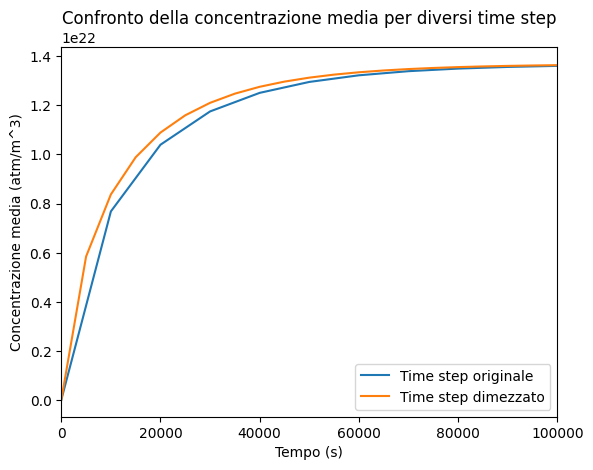

In [8]:
# Funzione per eseguire la simulazione con un dato time step
def run_simulation(time_step, n_iter):
    sol_new_C = np.zeros((sFO_Px, n_iter+1))  # Reset della soluzione
    average_C = np.zeros(n_iter)  # Reset della concentrazione media

    lhs_static = mass_C + time_step * stiff_C
    lhs_static = lhs_static.toarray()  # Necessario per LU
    rhs_static = time_step * (SOURCE_C * forc_C)
    LU, PIV = sp.linalg.lu_factor(lhs_static)

    #Integrate using forward Euler up to the final time:
    for ii in range(n_iter):
        cur_time = ii * time_step

        # Stampa l'iterazione corrente e la concentrazione media
        print('Current time:', cur_time, 's')
        average_C[ii] = inte_C @ sol_new_C[mask_in_C, ii]
        print('Average concentration:', average_C[ii], 'atm/m^3\n')

        cur_rhs = mass_C.dot(sol_new_C[mask_in_C, ii:ii+1]) + rhs_static
        sol_new_C[mask_in_C, ii+1] = sp.linalg.lu_solve((LU, PIV), cur_rhs[:,0])
    
    # Print final time and final average temperature and concentration:
    print('Final time:', n_iter * time_step, 's')
    average_C[ii] = inte_C @ sol_new_C[mask_in_C, ii]
    print('Average concentration:', inte_C @ sol_new_C[mask_in_C, -1], 'atm/m^3')

    return average_C, sol_new_C


# Define final time, time increment:
TIME_FINAL = 1.00E+07  # [s]
TIME_DELTA = 1.00E+04  # [s]  con 20 ci mette 26 minuti
N_ITER = int(TIME_FINAL / TIME_DELTA)  # [-]
TIME_DELTA_HALF = TIME_DELTA / 2  # Time step dimezzato (s)
N_ITER_HALF = int(TIME_FINAL / TIME_DELTA_HALF)

print("TIME_FINAL:", TIME_FINAL)
print("TIME_DELTA:", TIME_DELTA)
print("N_ITER:", N_ITER)
print("TIME_DELTA_HALF:", TIME_DELTA_HALF)
print("N_ITER_HALF:", N_ITER_HALF)


# Simulazione con il time step originale
average_C_original, sol_new_C_original = run_simulation(TIME_DELTA,N_ITER)
    
# Simulazione con il time step dimezzato
average_C_half, sol_new_C_half = run_simulation(TIME_DELTA_HALF,N_ITER_HALF)

# Grafico per confrontare la concentrazione media
time_original = np.arange(N_ITER) * TIME_DELTA
time_half = np.arange(N_ITER_HALF) * TIME_DELTA_HALF
plt.plot(time_original, average_C_original, label='Time step originale')
plt.plot(time_half, average_C_half, label='Time step dimezzato')
plt.xlabel('Tempo (s)')
plt.ylabel('Concentrazione media (atm/m^3)')
plt.xlim([0, 1e5])
plt.legend()
plt.title('Confronto della concentrazione media per diversi time step')
plt.show()

#La concentrazione finale è = 1.3689093371500824e+22, le ultime cifre 

### Error

Errore relativo massimo: 8.265e+00%


/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_2116/4256240206.py:2: RuntimeWarning: invalid value encountered in divide
  relative_error = np.abs((average_C_half_interp - average_C_original) / average_C_half_interp)*100


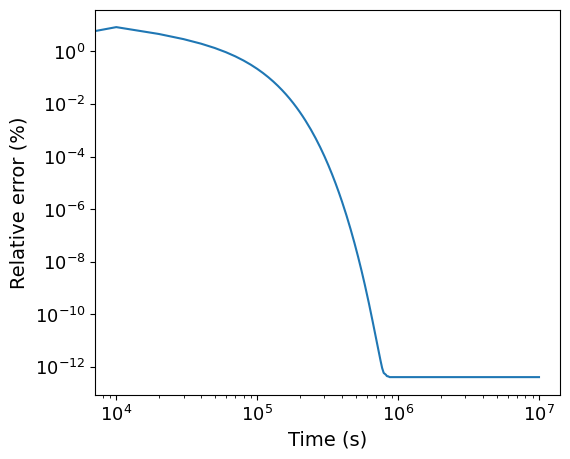

In [9]:
average_C_half_interp = np.interp(time_original, time_half, average_C_half)
relative_error = np.abs((average_C_half_interp - average_C_original) / average_C_half_interp)*100
relative_error[np.isnan(relative_error)] = 0                       # Evita NaN se ci sono divisioni per zero
print(f"Errore relativo massimo: {np.max(relative_error):.3e}%")

fig, (ax1) = plt.subplots(1,  figsize=[6,5])
ax1.set_xscale('log')  # Imposta la scala logaritmica per l'asse x
ax1.set_yscale('log')  # Imposta la scala logaritmica per l'asse y
ax1.plot(time_original, relative_error, label='Errore relativo')
ax1.set_xlabel('Time (s)', fontsize=14)
ax1.set_ylabel('Relative error (%)',fontsize=14)
ax1.tick_params(axis="x", labelsize=13)
ax1.tick_params(axis="y", labelsize=13)

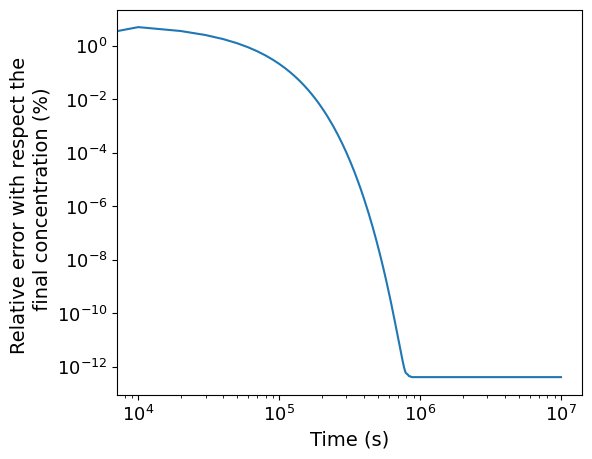

In [10]:
average_C_half_interp = np.interp(time_original, time_half, average_C_half)
relative_error = np.abs((average_C_half_interp - average_C_original) / average_C_half_interp[-1])*100


fig, (ax1) = plt.subplots(1,  figsize=[6,5])
ax1.set_xscale('log')  # Imposta la scala logaritmica per l'asse x
ax1.set_yscale('log')  # Imposta la scala logaritmica per l'asse y
ax1.plot(time_original, relative_error, label='Errore relativo')
ax1.set_xlabel('Time (s)', fontsize=14)
ax1.set_ylabel('Relative error with respect the \n final concentration (%)',fontsize=14)
ax1.tick_params(axis="x", labelsize=13)
ax1.tick_params(axis="y", labelsize=13)

In [11]:
np.savetxt('time step study/fast phenomenon/Fullorder_Cfield_time step 1e4.csv', sol_new_C_original[:, :], delimiter=',', fmt='%d')         #Salvo il campo di concentrazione ad ogni istante di tempo
np.savetxt('time step study/fast phenomenon/Fullorder_Cfield_half_time step 5e3.csv', sol_new_C_half[:, :], delimiter=',', fmt='%d')         #Salvo il campo di concentrazione ad ogni istante di tempo

7.756858721954264e+23


/Users/martina/Library/Python/3.9/lib/python/site-packages/matplotlib/tri/_triangulation.py:181: RuntimeWarning: invalid value encountered in cast
  triangles = np.asarray(triangles, dtype=np.int32)


La quota z al valore massimo della concentrazione è: 0.990515 m


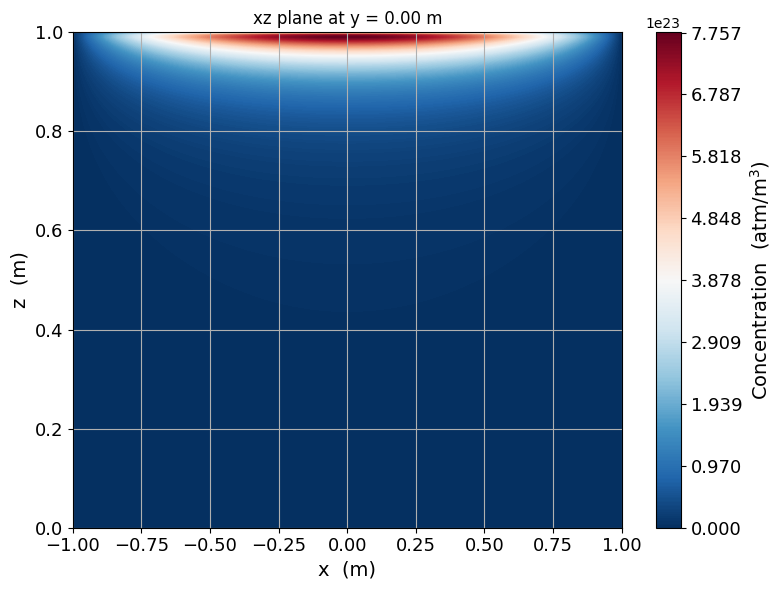

In [106]:
sol_new_C = np.loadtxt('time step study/fast phenomenon/Fullorder_Cfield.csv', delimiter=',')
field = sol_new_C[:, -1] / volume

field = np.hstack((field, field))
coord_x = np.hstack((coordinates_Px[:, 0], - coordinates_Px[:, 0]))
coord_z = np.hstack((coordinates_Px[:, 1],   coordinates_Px[:, 1]))

#Per farlo metà
#field = sol_new_C[:, -1] / volume
#coord_x = np.hstack((coordinates_Px[:, 0]))
#coord_y = np.hstack((coordinates_Px[:, 1]))

max_tick = np.max(field)
tick_step = np.max(field)/8
print(max_tick)
ticks = np.linspace(0, max_tick, int(max_tick / tick_step) + 1)

plt.figure(figsize=(8, 6))
contour = plt.tricontourf(coord_x, coord_z, field, 400, cmap='RdBu_r', vmin=0, vmax = max_tick)
cbar = plt.colorbar(contour, ticks=ticks)       # Usa '%.2f' per due cifre decimali
cbar.ax.tick_params(labelsize=13)  # Dimensione del testo della colorbar
cbar.set_label('Concentration  (atm/m$^3$)', fontsize=14)
 
    
#plt.ylim((1-2e-2, 1))  #zoom sulla zona ad alto gradiente
plt.tick_params(axis="y", labelsize=13)
plt.tick_params(axis='x', labelsize=13)
plt.xlabel('x  (m)',fontsize=14)
plt.ylabel('z  (m)',fontsize=14)
plt.title('xz plane at y = 0.00 m')
plt.grid(True)
plt.tight_layout()

# Trova la coordinata z a cui corrisponde il valore massimo della concentrazione
max_index = np.argmax(field)  # Indice del valore massimo
z_max = coord_z[max_index]  # Coordinata z del massimo valore
print(f"La quota z al valore massimo della concentrazione è: {z_max:.6f} m")

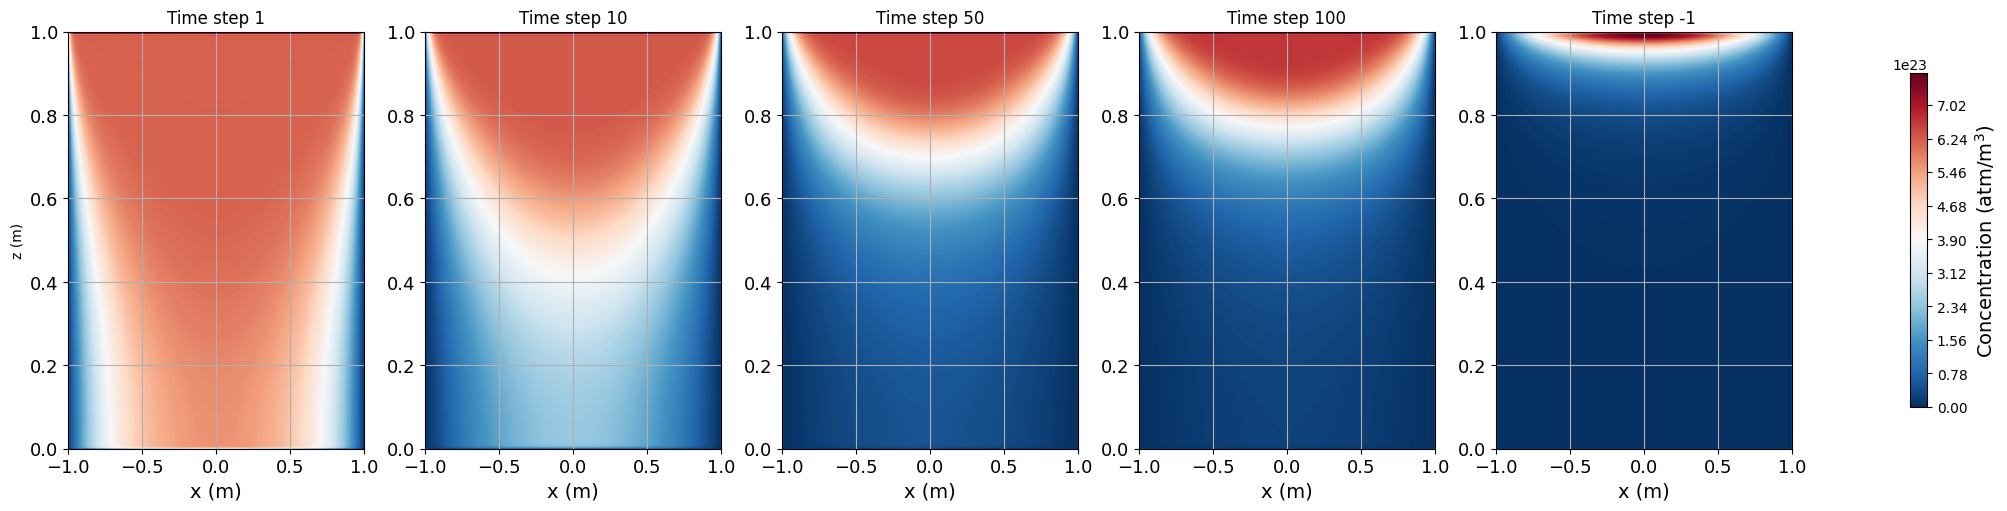

In [107]:
sol_new_C = np.loadtxt('time step study/fast phenomenon/Fullorder_Cfield.csv', delimiter=',')
timesteps = [1, 10, 50, 100, -1]


#Per farlo metà
#field = sol_new_C[:, -1] / volume
#coord_x = np.hstack((coordinates_Px[:, 0]))
#coord_y = np.hstack((coordinates_Px[:, 1]))

fig, axes = plt.subplots(1, len(timesteps), figsize=(20, 5), constrained_layout=True)
for i, t in enumerate(timesteps):
    field = sol_new_C[:, t] / volume
    field = np.hstack((field, field))
    coord_x = np.hstack((coordinates_Px[:, 0], - coordinates_Px[:, 0]))
    coord_z = np.hstack((coordinates_Px[:, 1],   coordinates_Px[:, 1]))

    max_tick = np.max(field)
    tick_step = max_tick / 8 if max_tick > 0 else 1
    ticks = np.linspace(0, max_tick, int(max_tick / tick_step) + 1)

    contour = axes[i].tricontourf(coord_x, coord_z, field, 400, cmap='RdBu_r', vmin=0, vmax=max_tick)
    axes[i].tick_params(axis="y", labelsize=13)
    axes[i].tick_params(axis="x", labelsize=13)
    axes[i].set_title(f'Time step {t}')
    axes[i].set_xlabel('x (m)',fontsize=14)
    axes[i].grid(True)

axes[0].set_ylabel('z (m)')
cbar = fig.colorbar(contour, ax=axes.ravel().tolist(), shrink=0.8)
cbar.set_label('Concentration (atm/m$^3$)', fontsize=14)


 
    
#plt.ylim((1-2e-2, 1))  #zoom sulla zona ad alto gradiente
# plt.tick_params(axis="y", labelsize=13)
# plt.tick_params(axis='x', labelsize=13)
# plt.xlabel('x  (m)',fontsize=14)
# plt.ylabel('z  (m)',fontsize=14)
# plt.title('xz plane at y = 0.00 m')
# plt.grid(True)
# plt.tight_layout()
#plt.savefig('plot/reference case/FOM_xz.png', bbox_inches='tight')


### **Diffusività minima - fenomeno lento**

[[8.36340491e-61]
 [8.36340491e-61]
 [8.36340491e-61]
 ...
 [8.36340491e-61]
 [8.36340491e-61]
 [8.36340491e-61]]


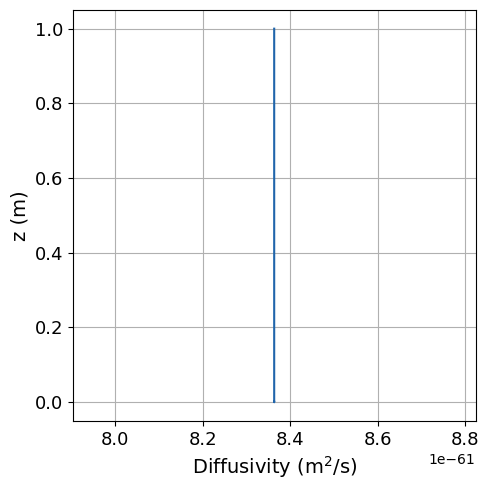

In [12]:
# Define parameters ranges:
MIN_FR, MAX_FR = 0.00, 5.00E+19        
MIN_K, MAX_K =  0.9, 8.00    
MIN_LL, MAX_LL = 0.1E-3, 1.50E-3
MIN_BC, MAX_BC = 300, 2.5E+03 

# Lettura dei parametri di riferimento dal file JSON
with open("reference case/Reference_parameters.json", "r") as json_file:
    parameters = json.load(json_file)
N_BOLT = parameters["N_BOLT"]  
FISSION_ENERGY = parameters["FISSION_ENERGY"]         

#Scelti seguendo la logica
FISSION_RATE = MIN_FR              
LENGTH = MIN_LL              
FUEL_THERMAL_CONDUCTIVITY = MAX_K
T_BC = MIN_BC
GAMMA_T = (FISSION_RATE * FISSION_ENERGY * LENGTH**2)/(FUEL_THERMAL_CONDUCTIVITY)

def ALPHA_C(ZZ, T_BC=T_BC, GAMMA_T=GAMMA_T, FISSION_RATE=FISSION_RATE):
    return 7.60E-10 * np.exp(- 4.86E-19 / (T_BC + GAMMA_T * (1 - ZZ**2) / 2) / N_BOLT) + \
           5.64E-25 * np.exp(- 1.91E-19 / (T_BC + GAMMA_T * (1 - ZZ**2) / 2) / N_BOLT) * np.sqrt(FISSION_RATE) + \
           8.00E-40 * FISSION_RATE

coordinates_Pq = FFvector_fread('mesh_utilities/vv_cc_Pq.btxt')
print(ALPHA_C(coordinates_Pq[:, 1:2]))

cmap = plt.get_cmap('RdBu')
color = cmap(0.9)
fig, (ax1) = plt.subplots(1, figsize=(5,5))
ax1.plot( ALPHA_C(coordinates_Pq[:, 1:2]), coordinates_Pq[:, 1:2], label = '$T_\infty$', color=color, linewidth=1.5)
ax1.tick_params(axis="y", labelsize=13)
ax1.tick_params(axis='x', labelsize=13)
ax1.ticklabel_format(useOffset=False)

#ax1.set_ylim([0, 1])
#ax1.set_xlim([2000, 2250])
ax1.set_ylabel('z (m)',fontsize=14)
ax1.set_xlabel(rf'Diffusivity (m$^2$/s)',fontsize=14)
ax1.grid()
plt.tight_layout()
plt.savefig('plot/Temperature profile.pdf', bbox_inches='tight') 

Minima diffusività trovata: 8.000e-38 m^2/s
Parametri corrispondenti:
  - FISSION_RATE: 1.000e+02
  - FUEL_THERMAL_CONDUCTIVITY: 0.900
  - LENGTH: 1.000e-04
  - T_BC: 300.0


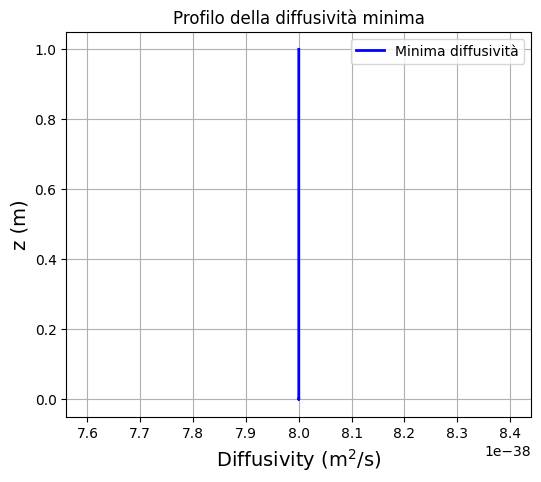

In [74]:
# Lettura parametri di riferimento
with open("reference case/Reference_parameters.json", "r") as json_file:
    parameters = json.load(json_file)
N_BOLT = parameters["N_BOLT"]
FISSION_ENERGY = parameters["FISSION_ENERGY"]

# Definizione dei range dei parametri
MIN_FR, MAX_FR = 100, 5.00E+19        
MIN_K, MAX_K =  0.9, 8.00    
MIN_LL, MAX_LL = 0.1E-3, 1.50E-3
MIN_BC, MAX_BC = 300, 2.5E+03 

# Discretizzazione dei parametri (scegli un numero di punti sensato)
N_POINTS = 10  # Puoi aumentare per maggiore precisione
FR_vals = np.linspace(MIN_FR, MAX_FR, N_POINTS)   #sequenza di N-points equidistanti nell'intervallo
K_vals = np.linspace(MIN_K, MAX_K, N_POINTS)
LL_vals = np.linspace(MIN_LL, MAX_LL, N_POINTS)
BC_vals = np.linspace(MIN_BC, MAX_BC, N_POINTS)

# Creazione tutte le combinazioni possibili
param_combinations = itertools.product(FR_vals, K_vals, LL_vals, BC_vals) 

# Definizione della funzione ALPHA_C
def ALPHA_C(ZZ, T_BC, GAMMA_T, FISSION_RATE):
    return 7.60E-10 * np.exp(- 4.86E-19 / (T_BC + GAMMA_T * (1 - ZZ**2) / 2) / N_BOLT) + \
           5.64E-25 * np.exp(- 1.91E-19 / (T_BC + GAMMA_T * (1 - ZZ**2) / 2) / N_BOLT) * np.sqrt(FISSION_RATE) + \
           8.00E-40 * FISSION_RATE

# Creiamo una griglia di punti ZZ lungo l'asse corto per valutare la diffusività
coordinates_Pq = FFvector_fread('mesh_utilities/vv_cc_Pq.btxt')
ZZ_vals =coordinates_Pq[:, 1:2]  # Normalizzato tra -1 e 1

# Variabili per il massimo
min_diffusivity = np.inf
best_params_min = None

# Iteriamo su tutte le combinazioni
for FR, K, LL, BC in param_combinations:
    GAMMA_T = (FR * FISSION_ENERGY * LL**2) / K
    diffusivity_values = ALPHA_C(ZZ_vals, BC, GAMMA_T, FR)
    
    # Troviamo il massimo valore di diffusività per questa configurazione
    local_min = np.min(diffusivity_values)

    # Se è il minimo globale finora, lo aggiorniamo
    if local_min < min_diffusivity:
        min_diffusivity = local_min
        best_params_min = (FR, K, LL, BC)

# Output dei risultati per la diffusività minima
print(f"Minima diffusività trovata: {min_diffusivity:.3e} m^2/s")
print(f"Parametri corrispondenti:")
print(f"  - FISSION_RATE: {best_params_min[0]:.3e}")
print(f"  - FUEL_THERMAL_CONDUCTIVITY: {best_params_min[1]:.3f}")
print(f"  - LENGTH: {best_params_min[2]:.3e}")
print(f"  - T_BC: {best_params_min[3]:.1f}")

# Plot della diffusività lungo ZZ per i parametri migliori (minima diffusività)
GAMMA_T_best_min = (best_params_min[0] * FISSION_ENERGY * best_params_min[2]**2) / best_params_min[1]
best_diffusivity_values_min = ALPHA_C(ZZ_vals, best_params_min[3], GAMMA_T_best_min, best_params_min[0])

plt.figure(figsize=(6,5))
plt.plot(best_diffusivity_values_min, ZZ_vals, label='Minima diffusività', color='b', linewidth=2)
plt.xlabel(r'Diffusivity (m$^2$/s)', fontsize=14)
plt.ylabel('z (m)', fontsize=14)
plt.grid()
plt.legend()
plt.title("Profilo della diffusività minima")
plt.show()

In [75]:
with open("reference case/Reference_parameters.json", "r") as json_file:
    parameters = json.load(json_file)

N_AVOG = parameters["N_AVOG"]  
N_BOLT = parameters["N_BOLT"]  
FISSION_ENERGY = parameters["FISSION_ENERGY"]  
FISSION_RATE = best_params_min[0]                   
RADIUS = 1e-05
LENGTH = best_params_min[2]
FISSION_YIELD = parameters["FISSION_YIELD"]                 
FUEL_THERMAL_CONDUCTIVITY = best_params_min[1]
T_BC = best_params_min[3]  
C_BC = parameters["C_BC"]  

SOURCE_C = FISSION_RATE * FISSION_YIELD         #[atm / (m^3 s)]
GAMMA_T = (FISSION_RATE * FISSION_ENERGY * LENGTH**2)/(FUEL_THERMAL_CONDUCTIVITY)
     
# Define reference temperature, concentration and linear diffusion parameters:
T_IC  = T_BC # [K]
C_IC = C_BC  # [atm / m^3]


# Define function evaluating the concentration diffusion coefficient at given z coordinated provided the problem parameters:
def ALPHA_C(ZZ, T_BC=T_BC, GAMMA_T=GAMMA_T, FISSION_RATE=FISSION_RATE):
    return 7.60E-10 * np.exp(- 4.86E-19 / (T_BC + GAMMA_T * (1 - ZZ**2) / 2) / N_BOLT) + \
           5.64E-25 * np.exp(- 1.91E-19 / (T_BC + GAMMA_T * (1 - ZZ**2) / 2) / N_BOLT) * np.sqrt(FISSION_RATE) + \
           8.00E-40 * FISSION_RATE

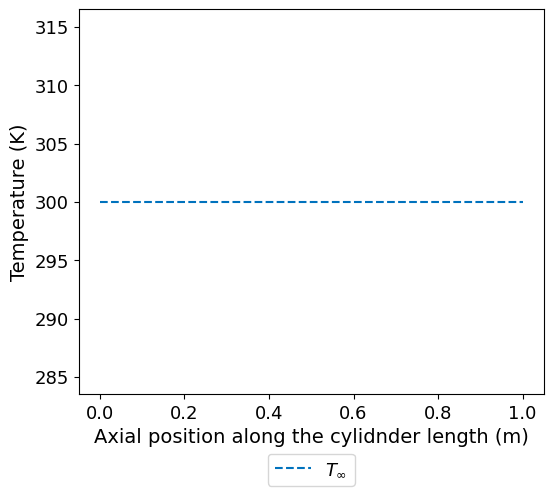

In [76]:
fig, (ax1) = plt.subplots(1, figsize=(6,5))
ax1.plot(np.linspace(0, 1,1000), T_BC + GAMMA_T * (1 - np.linspace(0, 1,1000)**2) / 2, '--',label = '$T_\infty$', color='#0072bd', linewidth=1.5)

ax1.tick_params(axis="y", labelsize=13)
ax1.tick_params(axis='x', labelsize=13)
ax1.ticklabel_format(useOffset=False)
ax1.set_xlabel('Axial position along the cylidnder length (m)',fontsize=14)
ax1.set_ylabel('Temperature (K)',fontsize=14)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), fancybox=True, shadow=False, ncol=2, fontsize=13)


In [77]:
# Load coordinates:
coordinates_Px = FFvector_fread('mesh_utilities/vv_cc_Px.btxt')
coordinates_Pq = FFvector_fread('mesh_utilities/vv_cc_Pq.btxt')

# Identify degrees of freedom of the Px and Pq spaces:
sFO_Px = coordinates_Px.shape[0]
sFO_Pq = coordinates_Pq.shape[0]
print(rf'Degree of freedom = {sFO_Px}')

# Define vector of all Px indeces:
mask_all = np.arange(sFO_Px, dtype=int)

# Identify indeces of the top, bottom and middle boundaries in Px:
mask_inf_bc = mask_all[np.isclose([coordinates_Px[ii, 1] for ii in range(sFO_Px)], np.zeros((sFO_Px)))]
mask_sup_bc = mask_all[np.isclose([coordinates_Px[ii, 1] for ii in range(sFO_Px)], np.ones((sFO_Px)))]
mask_mid_bc = mask_all[np.isclose([coordinates_Px[ii, 0] for ii in range(sFO_Px)], np.zeros((sFO_Px)))]
mask_ext_bc = mask_all[np.isclose([coordinates_Px[ii, 0] for ii in range(sFO_Px)], np.ones((sFO_Px)))]

# Identify indeces of the Dirichlet b.c. for the temperature and concentration field:
mask_bc_T = np.fromiter(set(mask_sup_bc), int)
mask_bc_C = np.fromiter(set(mask_sup_bc) | set(mask_ext_bc) | set(mask_inf_bc), int)

# Identify indeces of the interior for the temperature and concentration field:
mask_in_T = [ii for ii in mask_all if ii not in mask_bc_T]
mask_in_C = [ii for ii in mask_all if ii not in mask_bc_C]

Degree of freedom = 10201


In [78]:
# Import mass matrices on the Px and on the Pq space:
mass_Px = FFmatrix_fread('mesh_utilities/ww_mm_Px.btxt')
mass_Pq = FFmatrix_fread('mesh_utilities/ww_mm_Pq.btxt')
mass_Pm = FFmatrix_fread('mesh_utilities/ww_uu_Px_Pq.btxt')

# Extract integration weights and diagonal matrix with their inverse:
weights_Pq = mass_Pq.diagonal()
project_Pq = sparse.diags(np.reciprocal(weights_Pq))

# Import map from Px to Pq and to the dx, dy, dz derivative evaluated in Pq:
PxtoPquu_C = project_Pq.dot(FFmatrix_fread('mesh_utilities/ww_uu_Px_Pq.btxt')[:, mask_in_C])
PxtoPqdx_C = project_Pq.dot(FFmatrix_fread('mesh_utilities/ww_dx_Px_Pq.btxt')[:, mask_in_C])
PxtoPqdy_C = project_Pq.dot(FFmatrix_fread('mesh_utilities/ww_dy_Px_Pq.btxt')[:, mask_in_C])

# Define weights for the integration in polar coordinates:
polar_weights_Pq = np.multiply(coordinates_Pq[:, 0], weights_Pq)

# Compute volume of the domain:
volume = np.dot(np.ones(sFO_Pq), polar_weights_Pq)

# Assemble mass matrix and projected forcing term:
forc_C = PxtoPquu_C.T.dot(polar_weights_Pq[:, None])
mass_C = PxtoPquu_C.T.dot(PxtoPquu_C.multiply(polar_weights_Pq[:, None]))
inte_C = PxtoPquu_C.T.dot(polar_weights_Pq) / volume

# Assemble a function assembling the stiffness matrix at a given time:
stiff_C = PxtoPqdx_C.T.dot(PxtoPqdx_C.multiply(ALPHA_C(coordinates_Pq[:, 1:2]) / RADIUS**2 * polar_weights_Pq[:, None])) + \
          PxtoPqdy_C.T.dot(PxtoPqdy_C.multiply(ALPHA_C(coordinates_Pq[:, 1:2]) / LENGTH**2 * polar_weights_Pq[:, None]))

Current time: 0.0 s
Average concentration: 0.0 atm/m^3

Current time: 1e+27 s
Average concentration: 2.878797909173343e+27 atm/m^3

Current time: 2e+27 s
Average concentration: 3.348763099154628e+27 atm/m^3

Current time: 3.0000000000000003e+27 s
Average concentration: 3.428938563855353e+27 atm/m^3

Current time: 4e+27 s
Average concentration: 3.4427707349790285e+27 atm/m^3

Current time: 5e+27 s
Average concentration: 3.445167239739039e+27 atm/m^3

Current time: 6.000000000000001e+27 s
Average concentration: 3.445583388339853e+27 atm/m^3

Current time: 7e+27 s
Average concentration: 3.4456557610845227e+27 atm/m^3

Current time: 8e+27 s
Average concentration: 3.4456683617283314e+27 atm/m^3

Current time: 9e+27 s
Average concentration: 3.445670557557982e+27 atm/m^3

Current time: 1e+28 s
Average concentration: 3.4456709404894846e+27 atm/m^3

Current time: 1.1e+28 s
Average concentration: 3.4456710073095594e+27 atm/m^3

Current time: 1.2000000000000001e+28 s
Average concentration: 3.4456

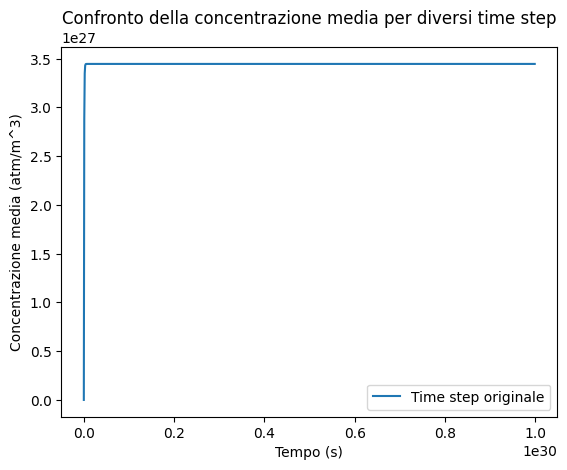

In [82]:
# Funzione per eseguire la simulazione con un dato time step
def run_simulation(time_step, n_iter):
    sol_new_C = np.zeros((sFO_Px, n_iter+1))  # Reset della soluzione
    average_C = np.zeros(n_iter)  # Reset della concentrazione media

    lhs_static = mass_C + time_step * stiff_C
    lhs_static = lhs_static.toarray()  # Necessario per LU
    rhs_static = time_step * (SOURCE_C * forc_C)
    LU, PIV = sp.linalg.lu_factor(lhs_static)

    #Integrate using forward Euler up to the final time:
    for ii in range(n_iter):
        cur_time = ii * time_step

        # Stampa l'iterazione corrente e la concentrazione media
        print('Current time:', cur_time, 's')
        average_C[ii] = inte_C @ sol_new_C[mask_in_C, ii]
        print('Average concentration:', average_C[ii], 'atm/m^3\n')

        cur_rhs = mass_C.dot(sol_new_C[mask_in_C, ii:ii+1]) + rhs_static
        sol_new_C[mask_in_C, ii+1] = sp.linalg.lu_solve((LU, PIV), cur_rhs[:,0])
    
    # Print final time and final average temperature and concentration:
    print('Final time:', n_iter * time_step, 's')
    average_C[ii] = inte_C @ sol_new_C[mask_in_C, ii]
    print('Average concentration:', inte_C @ sol_new_C[mask_in_C, -1], 'atm/m^3')

    return average_C, sol_new_C

# Define final time, time increment:
TIME_FINAL = 1.00E+30  # [s]
TIME_DELTA = 1.00E+27  # [s]
N_ITER = int(TIME_FINAL / TIME_DELTA)  # [-]

average_C_original, sol_new_C_original = run_simulation(TIME_DELTA,N_ITER)
time_original = np.arange(N_ITER) * TIME_DELTA
plt.plot(time_original, average_C_original, label='Time step originale')
plt.xlabel('Tempo (s)')
plt.ylabel('Concentrazione media (atm/m^3)')
plt.legend()
plt.title('Confronto della concentrazione media per diversi time step')
plt.show()


In [83]:
np.savetxt('time step study/slow phenomenon/Fullorder_Cfield.csv', sol_new_C_original[:, :], delimiter=',', fmt='%d')         #Salvo il campo di concentrazione ad ogni istante di tempo

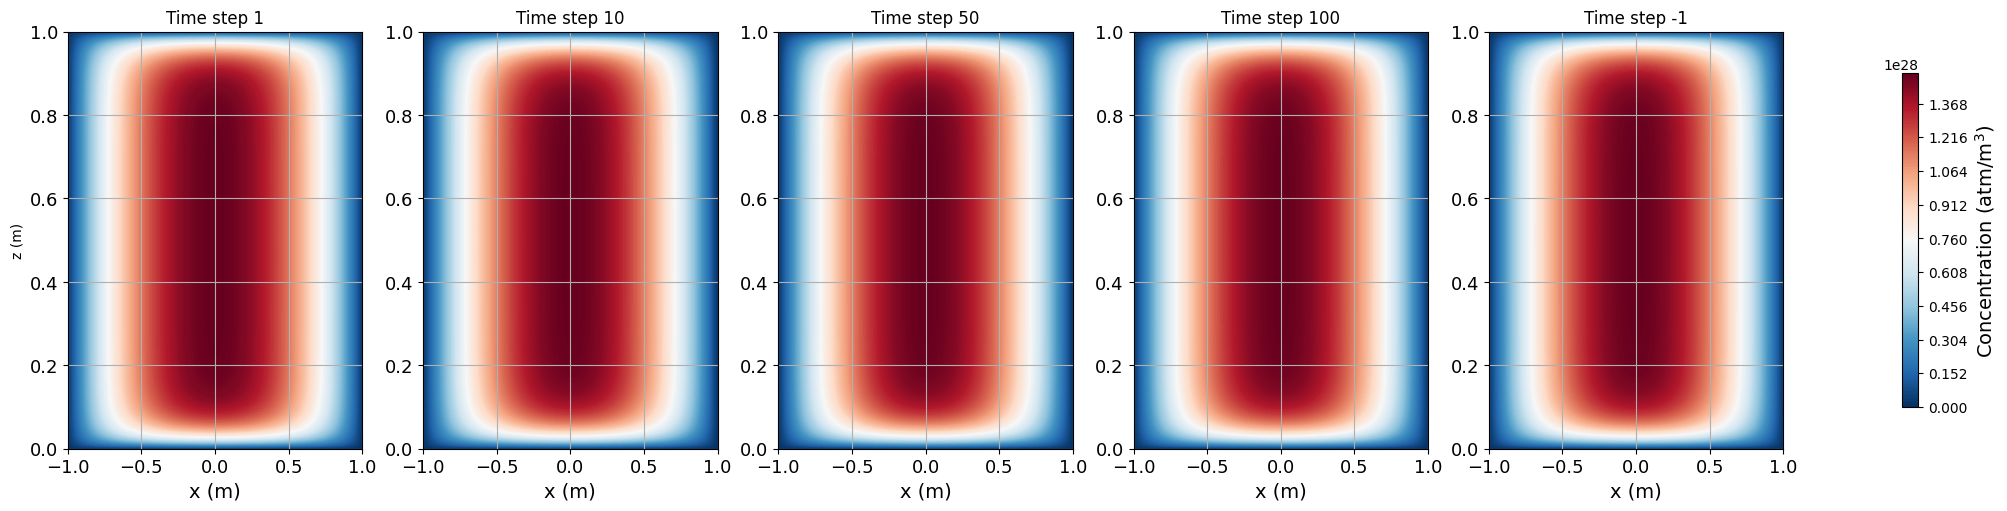

In [84]:
sol_new_C = np.loadtxt('time step study/slow phenomenon/Fullorder_Cfield.csv', delimiter=',')
timesteps = [1, 10, 50, 100, -1]


#Per farlo metà
#field = sol_new_C[:, -1] / volume
#coord_x = np.hstack((coordinates_Px[:, 0]))
#coord_y = np.hstack((coordinates_Px[:, 1]))

fig, axes = plt.subplots(1, len(timesteps), figsize=(20, 5), constrained_layout=True)
for i, t in enumerate(timesteps):
    field = sol_new_C[:, t] / volume
    field = np.hstack((field, field))
    coord_x = np.hstack((coordinates_Px[:, 0], - coordinates_Px[:, 0]))
    coord_z = np.hstack((coordinates_Px[:, 1],   coordinates_Px[:, 1]))

    max_tick = np.max(field)
    tick_step = max_tick / 8 if max_tick > 0 else 1
    ticks = np.linspace(0, max_tick, int(max_tick / tick_step) + 1)

    contour = axes[i].tricontourf(coord_x, coord_z, field, 400, cmap='RdBu_r', vmin=0, vmax=max_tick)
    axes[i].tick_params(axis="y", labelsize=13)
    axes[i].tick_params(axis="x", labelsize=13)
    axes[i].set_title(f'Time step {t}')
    axes[i].set_xlabel('x (m)',fontsize=14)
    axes[i].grid(True)

axes[0].set_ylabel('z (m)')
cbar = fig.colorbar(contour, ax=axes.ravel().tolist(), shrink=0.8)
cbar.set_label('Concentration (atm/m$^3$)', fontsize=14)


#plt.ylim((1-2e-2, 1))  #zoom sulla zona ad alto gradiente
# plt.tick_params(axis="y", labelsize=13)
# plt.tick_params(axis='x', labelsize=13)
# plt.xlabel('x  (m)',fontsize=14)
# plt.ylabel('z  (m)',fontsize=14)
# plt.title('xz plane at y = 0.00 m')
# plt.grid(True)
# plt.tight_layout()
#plt.savefig('plot/reference case/FOM_xz.png', bbox_inches='tight')
